# Installs & Imports

In [1]:
import math
from itertools import product
from functools import lru_cache
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.discrete.discrete_model as dm
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from scipy.stats import poisson, binom, nbinom, norm
from statsmodels.base.model import GenericLikelihoodModel, GenericLikelihoodModelResults
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Load the Data

In [2]:
# Load the STRIKES dataset from the 'Ecdat' package
strikes_dataset = sm.datasets.get_rdataset(dataname='StrikeNb', package='Ecdat')
strikes_data = strikes_dataset.data.copy()

# Generate actual date information
strikes_data['date'] = pd.date_range(start='1968-01-01', periods=len(strikes_data), freq='MS')

In [3]:
# Display the first few rows of the dataset
print("=== Dataset Head ===")
display(strikes_data.head())

print("\n=== Dataset Tail ===")
display(strikes_data.tail())

=== Dataset Head ===


,strikes,output,time,date
0,5,0.01517,1,1968-01-01
1,4,0.00997,2,1968-02-01
2,6,0.01170,3,1968-03-01
3,16,0.00473,4,1968-04-01
4,5,0.01277,5,1968-05-01



=== Dataset Tail ===


,strikes,output,time,date
103,3,0.00134,104,1976-08-01
104,4,-0.12810,105,1976-09-01
105,6,-0.01538,106,1976-10-01
106,2,-0.00703,107,1976-11-01
107,3,-0.00003,108,1976-12-01


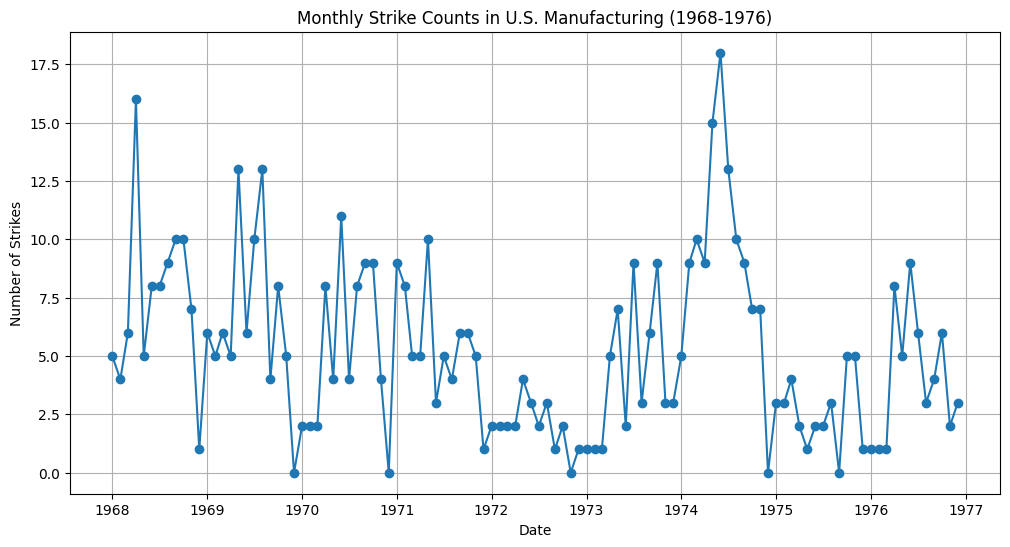

In [4]:
# Plot the time series of strikes
plt.figure(figsize=(12, 6))
plt.plot(strikes_data['date'], strikes_data['strikes'], marker='o', linestyle='-')
plt.title('Monthly Strike Counts in U.S. Manufacturing (1968-1976)')
plt.xlabel('Date')
plt.ylabel('Number of Strikes')
plt.grid(True)
plt.show()

# Explore the Data

In [5]:
# Display summary statistics
print("=== Summary Statistics ===")
display(strikes_data['strikes'].describe())

=== Summary Statistics ===


,strikes
count,108.000000
mean,5.240741
std,3.751312
min,0.000000
25%,2.000000
50%,5.000000
75%,8.000000
max,18.000000


In [6]:
# Check for overdispersion (Variance > Mean)
mean_strikes = strikes_data['strikes'].mean()
variance_strikes = strikes_data['strikes'].var()
print(f"Mean of Strikes: {mean_strikes:.2f}")
print(f"Variance of Strikes: {variance_strikes:.2f}")

if variance_strikes > mean_strikes:
    print("The data is overdispersed (Variance > Mean).")
else:
    print("The data is not overdispersed (Variance <= Mean).")

Mean of Strikes: 5.24
Variance of Strikes: 14.07
The data is overdispersed (Variance > Mean).


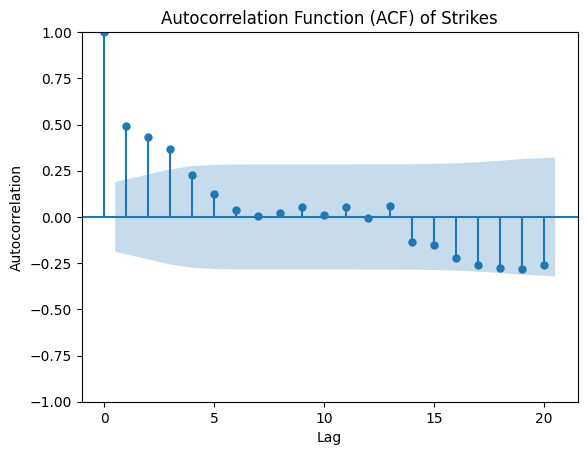

In [7]:
# Check autocorrelation using ACF plot
tsa.plot_acf(strikes_data['strikes'], lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of Strikes')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Preprocess the Data

In [8]:
def create_percent_change(df, target):
    """
    Create a 'percent_change' column for the target variable.

    Parameters:
    - df: Pandas DataFrame.
    - target: String, name of the target column.

    Returns:
    - DataFrame with an added 'percent_change' column.
    """
    df[f'{target}_percent_change'] = df[target].pct_change() * 100
    # Replace infinite values with 0
    df[f'{target}_percent_change'].replace([np.inf, -np.inf], 0, inplace=True)
    return df

# Apply 'percent_change' to 'strikes'
strikes_data = create_percent_change(strikes_data, 'strikes')

In [9]:
def create_spike_indicator(df, target, quantile=0.95):
    """
    Create a binary 'spike' indicator where values above a certain quantile are marked as spikes.

    Parameters:
    - df: Pandas DataFrame.
    - target: String, name of the target column.
    - quantile: Float, quantile to define spike threshold.

    Returns:
    - DataFrame with an added 'spike' column.
    """
    spike_threshold = df[target].quantile(quantile)
    df['spike'] = (df[target] > spike_threshold).astype(int)
    return df

# Apply 'spike' indicator to 'strikes'
strikes_data = create_spike_indicator(strikes_data, 'strikes')

In [10]:
def create_zero_count_indicator(df, target):
    """
    Create a binary 'zero_count' indicator where values are marked as 0.

    Parameters:
    - df: Pandas DataFrame.
    - target: String, name of the target column.

    Returns:
    - DataFrame with an added 'zero_count' column.
    """
    df['zero_count'] = (df[target] == 0).astype(int)
    return df

# Apply 'zero_count' indicator to 'strikes'
strikes_data = create_zero_count_indicator(strikes_data, 'strikes')

In [11]:
# Verify derived variables
print("After Creating Derived Variables:")
display(strikes_data[['strikes', 'strikes_percent_change', 'spike', 'zero_count']].head(5))

After Creating Derived Variables:


,strikes,strikes_percent_change,spike,zero_count
0,5,NaN,0,0
1,4,-20.000000,0,0
2,6,50.000000,0,0
3,16,166.666667,1,0
4,5,-68.750000,0,0


In [12]:
def create_lagged_features(df, target, lags):
    """
    Create lagged features for a specified target variable.

    Parameters:
    - df: Pandas DataFrame.
    - target: String, name of the target column.
    - lags: Integer, number of lags to create.

    Returns:
    - DataFrame with added lagged features.
    """
    for lag in range(1, lags + 1):
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df

# Apply lagging to 'strikes'
N = 2  # Number of lags
strikes_data = create_lagged_features(strikes_data, 'strikes', N)

In [13]:
# Apply lagging to exogenous variables
# Define exogenous variables to lag
exog_vars_to_lag = ['output', 'strikes_percent_change', 'spike', 'zero_count']

# Check if all exogenous variables exist
missing_vars = [var for var in exog_vars_to_lag if var not in strikes_data.columns]
if missing_vars:
    raise ValueError(f"The following exogenous variables are missing from the dataset and cannot be lagged: {missing_vars}")

# Apply lagging to each exogenous variable
for var in exog_vars_to_lag:
    strikes_data = create_lagged_features(strikes_data, var, N)

In [14]:
# Verify lagged variables
lagged_cols = [f'strikes_lag_{lag}' for lag in range(1, N+1)]
for var in exog_vars_to_lag:
    lagged_cols += [f'{var}_lag_{lag}' for lag in range(1, N+1)]
print("After Creating Lagged Variables:")
display(strikes_data[lagged_cols].head(5))

After Creating Lagged Variables:


,strikes_lag_1,strikes_lag_2,output_lag_1,output_lag_2,strikes_percent_change_lag_1,strikes_percent_change_lag_2,spike_lag_1,spike_lag_2,zero_count_lag_1,zero_count_lag_2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,NaN,0.01517,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,4.0,5.0,0.00997,0.01517,-20.000000,NaN,0.0,0.0,0.0,0.0
3,6.0,4.0,0.01170,0.00997,50.000000,-20.0,0.0,0.0,0.0,0.0
4,16.0,6.0,0.00473,0.01170,166.666667,50.0,1.0,0.0,0.0,0.0


In [15]:
def generate_fourier_terms(df, period, K):
    """
    Generate Fourier terms for capturing seasonality.

    Parameters:
    - df: Pandas DataFrame with a 'date' column.
    - period: Integer, number of periods in a complete seasonal cycle (e.g., 12 for monthly data).
    - K: Integer, number of Fourier harmonics.

    Returns:
    - DataFrame containing sine and cosine Fourier terms.
    """
    t = np.arange(len(df))
    fourier_terms = {}
    for k in range(1, K + 1):
        fourier_terms[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        fourier_terms[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return pd.DataFrame(fourier_terms, index=df.index)

In [16]:
# Define seasonality parameters
period = 12  # Monthly data with yearly seasonality
K = 1        # Number of Fourier harmonics

# Generate and concatenate Fourier terms
fourier_terms_df = generate_fourier_terms(strikes_data, period, K)
strikes_data = pd.concat([strikes_data, fourier_terms_df], axis=1)

# Verify Fourier Terms
print("After Generating Fourier Terms:")
display(strikes_data[[f'sin_{k}' for k in range(1, K+1)] + [f'cos_{k}' for k in range(1, K+1)]].head(5))

After Generating Fourier Terms:


,sin_1,cos_1
0,0.000000,1.000000e+00
1,0.500000,8.660254e-01
2,0.866025,5.000000e-01
3,1.000000,6.123234e-17
4,0.866025,-5.000000e-01


In [17]:
# Display initial information
print(f"Total Observations: {len(strikes_data)}")

# Drop rows with any NaN values resulting from lagging
strikes_data_clean = strikes_data.dropna().reset_index(drop=True)
print(f"\nTotal Observations after Dropping NaNs: {len(strikes_data_clean)}")

Total Observations: 108

Total Observations after Dropping NaNs: 105


In [18]:
# Define split ratio
split_ratio = 0.8
split_point = int(len(strikes_data_clean) * split_ratio)

# Split the data
strikes_data_train = strikes_data_clean.iloc[:split_point].copy()
strikes_data_test = strikes_data_clean.iloc[split_point:].copy()

print(f"Training Set Size: {len(strikes_data_train)}")
print(f"Testing Set Size: {len(strikes_data_test)}")

Training Set Size: 84
Testing Set Size: 21


In [19]:
def validate_data(df, dataset_name):
    """
    Validate that the DataFrame contains no NaN or infinite values.

    Parameters:
    - df: Pandas DataFrame.
    - dataset_name: String, name of the dataset (e.g., 'Training Data').

    Returns:
    - None. Prints validation results.
    """
    nan_counts = df.isna().sum()
    if nan_counts.any():
        print(f"Warning: {dataset_name} contains NaN values.")
        print(nan_counts[nan_counts > 0])
    else:
        print(f"{dataset_name} is clean.")

    # Check for infinite values in numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    if np.isinf(numeric_df.values).any():
        print(f"Warning: {dataset_name} contains infinite values.")
    else:
        print(f"{dataset_name} has no infinite values.")

In [20]:
# Validate training data
validate_data(strikes_data_train, "Training Data")
print("\n")

# Validate testing data
validate_data(strikes_data_test, "Testing Data")

Training Data is clean.
Training Data has no infinite values.


Testing Data is clean.
Testing Data has no infinite values.


In [21]:
# Display sample data
print("Sample Training Data:")
display(strikes_data_train.head())
print("\n")
display(strikes_data_train.tail())
print("\n")
print("Sample Testing Data:")
display(strikes_data_test.head())
print("\n")
display(strikes_data_test.tail())

Sample Training Data:


,strikes,output,time,date,strikes_percent_change,spike,zero_count,strikes_lag_1,strikes_lag_2,output_lag_1,output_lag_2,strikes_percent_change_lag_1,strikes_percent_change_lag_2,spike_lag_1,spike_lag_2,zero_count_lag_1,zero_count_lag_2,sin_1,cos_1
0,16,0.00473,4,1968-04-01,166.666667,1,0,6.0,4.0,0.01170,0.00997,50.000000,-20.000000,0.0,0.0,0.0,0.0,1.000000e+00,6.123234e-17
1,5,0.01277,5,1968-05-01,-68.750000,0,0,16.0,6.0,0.00473,0.01170,166.666667,50.000000,1.0,0.0,0.0,0.0,8.660254e-01,-5.000000e-01
2,8,0.01138,6,1968-06-01,60.000000,0,0,5.0,16.0,0.01277,0.00473,-68.750000,166.666667,0.0,1.0,0.0,0.0,5.000000e-01,-8.660254e-01
3,8,0.00424,7,1968-07-01,0.000000,0,0,8.0,5.0,0.01138,0.01277,60.000000,-68.750000,0.0,0.0,0.0,0.0,1.224647e-16,-1.000000e+00
4,9,-0.00687,8,1968-08-01,12.500000,0,0,8.0,8.0,0.00424,0.01138,0.000000,60.000000,0.0,0.0,0.0,0.0,-5.000000e-01,-8.660254e-01


,strikes,output,time,date,strikes_percent_change,spike,zero_count,strikes_lag_1,strikes_lag_2,output_lag_1,output_lag_2,strikes_percent_change_lag_1,strikes_percent_change_lag_2,spike_lag_1,spike_lag_2,zero_count_lag_1,zero_count_lag_2,sin_1,cos_1
79,7,-0.00225,83,1974-11-01,0.000000,0,0,7.0,9.0,0.03458,0.05197,-22.222222,-10.000000,0.0,0.0,0.0,0.0,-8.660254e-01,0.500000
80,0,-0.04998,84,1974-12-01,-100.000000,0,1,7.0,7.0,-0.00225,0.03458,0.000000,-22.222222,0.0,0.0,0.0,0.0,-5.000000e-01,0.866025
81,3,-0.09771,85,1975-01-01,0.000000,0,0,0.0,7.0,-0.04998,-0.00225,-100.000000,0.000000,0.0,0.0,1.0,0.0,-1.714506e-15,1.000000
82,3,-0.12124,86,1975-02-01,0.000000,0,0,3.0,0.0,-0.09771,-0.04998,0.000000,-100.000000,0.0,0.0,0.0,1.0,5.000000e-01,0.866025
83,4,-0.13996,87,1975-03-01,33.333333,0,0,3.0,3.0,-0.12124,-0.09771,0.000000,0.000000,0.0,0.0,0.0,0.0,8.660254e-01,0.500000




Sample Testing Data:


,strikes,output,time,date,strikes_percent_change,spike,zero_count,strikes_lag_1,strikes_lag_2,output_lag_1,output_lag_2,strikes_percent_change_lag_1,strikes_percent_change_lag_2,spike_lag_1,spike_lag_2,zero_count_lag_1,zero_count_lag_2,sin_1,cos_1
84,2,-0.12590,88,1975-04-01,-50.0,0,0,4.0,3.0,-0.13996,-0.12124,33.333333,0.000000,0.0,0.0,0.0,0.0,1.000000e+00,7.104808e-15
85,1,-0.12224,89,1975-05-01,-50.0,0,0,2.0,4.0,-0.12590,-0.13996,-50.000000,33.333333,0.0,0.0,0.0,0.0,8.660254e-01,-5.000000e-01
86,2,-0.10443,90,1975-06-01,100.0,0,0,1.0,2.0,-0.12224,-0.12590,-50.000000,-50.000000,0.0,0.0,0.0,0.0,5.000000e-01,-8.660254e-01
87,2,-0.08656,91,1975-07-01,0.0,0,0,2.0,1.0,-0.10443,-0.12224,100.000000,-50.000000,0.0,0.0,0.0,0.0,-1.715743e-15,-1.000000e+00
88,3,-0.06279,92,1975-08-01,50.0,0,0,2.0,2.0,-0.08656,-0.10443,0.000000,100.000000,0.0,0.0,0.0,0.0,-5.000000e-01,-8.660254e-01


,strikes,output,time,date,strikes_percent_change,spike,zero_count,strikes_lag_1,strikes_lag_2,output_lag_1,output_lag_2,strikes_percent_change_lag_1,strikes_percent_change_lag_2,spike_lag_1,spike_lag_2,zero_count_lag_1,zero_count_lag_2,sin_1,cos_1
100,3,0.00134,104,1976-08-01,-50.000000,0,0,6.0,9.0,-0.00157,-0.00700,-33.333333,80.000000,0.0,0.0,0.0,0.0,-0.500000,-8.660254e-01
101,4,-0.12810,105,1976-09-01,33.333333,0,0,3.0,6.0,0.00134,-0.00157,-50.000000,-33.333333,0.0,0.0,0.0,0.0,-0.866025,-5.000000e-01
102,6,-0.01538,106,1976-10-01,50.000000,0,0,4.0,3.0,-0.12810,0.00134,33.333333,-50.000000,0.0,0.0,0.0,0.0,-1.000000,3.185939e-15
103,2,-0.00703,107,1976-11-01,-66.666667,0,0,6.0,4.0,-0.01538,-0.12810,50.000000,33.333333,0.0,0.0,0.0,0.0,-0.866025,5.000000e-01
104,3,-0.00003,108,1976-12-01,50.000000,0,0,2.0,6.0,-0.00703,-0.01538,-66.666667,50.000000,0.0,0.0,0.0,0.0,-0.500000,8.660254e-01


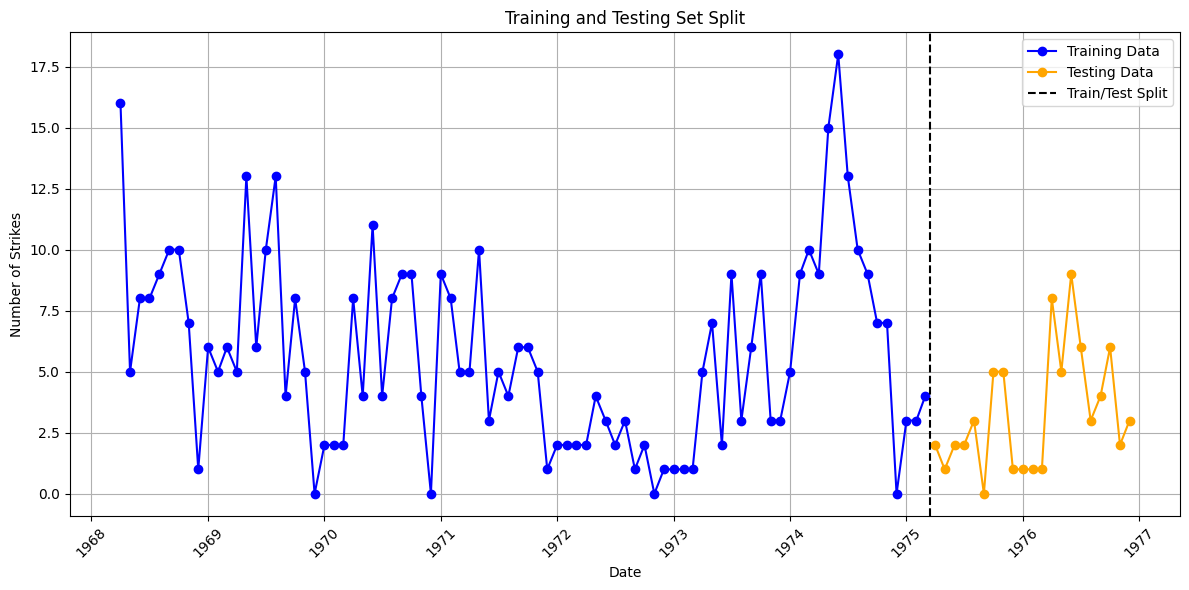

In [22]:
# Get the last train date and first test date
train_last_date = strikes_data_train['date'].iloc[-1]
test_first_date = strikes_data_test['date'].iloc[0]

# Calculate the average or midpoint between the two dates for an offset
split_line_position = train_last_date + (test_first_date - train_last_date) / 2

# Plot the train/test splits
plt.figure(figsize=(12, 6))
plt.plot(strikes_data_train['date'], strikes_data_train['strikes'], marker='o', linestyle='-', color='blue', label='Training Data')
plt.plot(strikes_data_test['date'], strikes_data_test['strikes'], marker='o', linestyle='-', color='orange', label='Testing Data')
plt.axvline(x=split_line_position, color='k', linestyle='--', label='Train/Test Split')
plt.title('Training and Testing Set Split')
plt.xlabel('Date')
plt.ylabel('Number of Strikes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Fit the Models

## Poisson Regression

In [23]:
# Define the regression formula
exog_vars = ['output', 'strikes_percent_change', 'spike', 'zero_count']
exog_lagged_terms = [f'{var}_lag_{lag}' for var in exog_vars for lag in range(1, N + 1)]
target_lagged_terms = [f'strikes_lag_{lag}' for lag in range(1, N + 1)]
fourier_terms = [f'sin_{k}' for k in range(1, K + 1)] + [f'cos_{k}' for k in range(1, K + 1)]
all_terms = exog_lagged_terms + target_lagged_terms + fourier_terms
expr_poisson = 'strikes ~ ' + ' + '.join(all_terms)

# Create design matrices using Patsy
y_train_poisson, X_train_poisson = dmatrices(expr_poisson, strikes_data_train, return_type='dataframe')
y_test_poisson, X_test_poisson = dmatrices(expr_poisson, strikes_data_test, return_type='dataframe')

# Fit the Poisson Regression Model
poisson_model = dm.Poisson(endog=y_train_poisson, exog=X_train_poisson)
poisson_results = poisson_model.fit(maxiter=100, disp=False)
print(poisson_results.summary())
print("\n")
print(poisson_results.summary2())

                          Poisson Regression Results                          
Dep. Variable:                strikes   No. Observations:                   84
Model:                        Poisson   Df Residuals:                       71
Method:                           MLE   Df Model:                           12
Date:                Sun, 24 Nov 2024   Pseudo R-squ.:                  0.1868
Time:                        05:08:38   Log-Likelihood:                -208.34
converged:                       True   LL-Null:                       -256.19
Covariance Type:            nonrobust   LLR p-value:                 3.853e-15
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.9517      0.149      6.375      0.000       0.659       1.244
output_lag_1                     2.8970      4.441      0.652      0.514     

## Negative Binomial Regression

In [24]:
# Define the regression formula
expr_nb = 'strikes ~ ' + ' + '.join(all_terms)

# Create design matrices using Patsy
y_train_nb, X_train_nb = dmatrices(expr_nb, strikes_data_train, return_type='dataframe')
y_test_nb, X_test_nb = dmatrices(expr_nb, strikes_data_test, return_type='dataframe')

# Fit the Negative Binomial Regression Model (NB2)
nb_model = dm.NegativeBinomial(endog=y_train_nb, exog=X_train_nb, loglike_method='nb2')
nb_results = nb_model.fit(maxiter=3000, method='ncg')
print("\n")
print(nb_results.summary())
print("\n")
print(nb_results.summary2())

Optimization terminated successfully.
         Current function value: 2.436954
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 2


                     NegativeBinomial Regression Results                      
Dep. Variable:                strikes   No. Observations:                   84
Model:               NegativeBinomial   Df Residuals:                       71
Method:                           MLE   Df Model:                           12
Date:                Sun, 24 Nov 2024   Pseudo R-squ.:                 0.09579
Time:                        05:08:55   Log-Likelihood:                -204.70
converged:                       True   LL-Null:                       -226.39
Covariance Type:            nonrobust   LLR p-value:                 1.954e-05
                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

## Poisson INAR Model

In [25]:
# Identify max counts in the data
max_counts = strikes_data_train['strikes'].max()
print(f"Maximum Count in Data: {max_counts}")

Maximum Count in Data: 18


In [26]:
# Top-level function for cached binomial PMF
@lru_cache(maxsize=None)
def binom_pmf_cached(j, y_prev, rho_i):
    """
    Cached binomial PMF to speed up computations.

    Parameters:
    - j: Number of successes.
    - y_prev: Number of trials.
    - rho_i: Probability of success.

    Returns:
    - Binomial PMF value.
    """
    return binom.pmf(j, y_prev, rho_i)

# Top-level function to compute total log probability for PoissonINAR
def compute_total_log_prob_pois(y_t, y_lags, rho, mu_t, max_j=max_counts):
    """
    Compute the log probability for a single observation in Poisson INAR.

    Parameters:
    - y_t: Observed count at time t.
    - y_lags: Array of lagged counts.
    - rho: Array of thinning parameters.
    - mu_t: Exponential of linear predictor at time t.
    - max_j: Maximum threshold to consider.

    Returns:
    - Log probability for observation t.
    """
    prob_y_t = 0.0
    j_ranges = [range(0, min(int(y_prev) + 1, max_j + 1)) for y_prev in y_lags]
    for j_tuple in product(*j_ranges):
        j_total = sum(j_tuple)
        if j_total > y_t:
            continue  # Invalid combination, skip

        p_combination = 1.0
        for i in range(len(j_tuple)):
            j_i = j_tuple[i]
            y_prev = y_lags[i]
            p_j_i = binom_pmf_cached(j_i, int(y_prev), rho[i])
            p_combination *= p_j_i

        p_k = poisson.pmf(y_t - j_total, mu_t)
        prob_y_t += p_combination * p_k

    prob_y_t = max(prob_y_t, 1e-10)  # Prevent log(0)
    return math.log(prob_y_t)

In [27]:
class PoissonINARResults(GenericLikelihoodModelResults):
    def __init__(self, model, mlefit, param_names):
        super().__init__(model, mlefit)
        # Store parameter names and mlefit for reference
        self._param_names = param_names
        self.mlefit = mlefit

    @property
    def params(self):
        # Wrap the parameters in a Pandas Series with names
        return pd.Series(self.mlefit.params, index=self._param_names)

    def summary(self, yname=None, xname=None, title=None, alpha=.05):
        if xname is None:
            xname = self._param_names
        # Create summary using super, passing custom parameter names
        return super().summary(yname=yname, xname=xname, title=title, alpha=alpha)

In [28]:
class PoissonINAR(GenericLikelihoodModel):
    def __init__(self, endog, exog, p=1, n_jobs=-1, **kwds):
        """
        Initialize the Poisson INAR model.

        Parameters:
        - endog: The dependent variable (array-like).
        - exog: The exogenous variables (array-like), excluding the lagged y's.
        - p: Number of lags (integer).
        - n_jobs: Number of parallel jobs (integer). Default -1 uses all available cores.
        """
        self.p = p  # Number of AR terms
        self.n_jobs = n_jobs  # Number of parallel jobs

        # Extract variable names if exog is a DataFrame
        if isinstance(exog, pd.DataFrame):
            self.var_names = exog.columns.tolist()
        else:
            self.var_names = [f'x{i+1}' for i in range(exog.shape[1])]

        super(PoissonINAR, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        """
        Compute the negative log-likelihood for each observation.

        Parameters:
        - params: The parameter vector [beta coefficients..., gamma1, gamma2, ..., gamma_p].

        Returns:
        - Array of negative log-likelihood values for each observation.
        """
        num_beta = self.exog.shape[1]
        beta = params[:num_beta]
        gamma = params[num_beta:]

        rho = 1.0 / (1.0 + np.exp(-gamma))  # rho = [rho1, rho2, ..., rho_p]
        mu = np.exp(np.dot(self.exog, beta))  # Linear predictor

        # Prepare the arguments for parallel processing
        obs_args = [
            (self.endog[t], self.endog[t - self.p:t], tuple(rho), mu[t])
            for t in range(self.p, len(self.endog))
        ]

        # Compute log probabilities in parallel using the 'threading' backend
        log_probs = Parallel(n_jobs=self.n_jobs, backend='threading')(
            delayed(compute_total_log_prob_pois)(y_t, y_lags, rho, mu_t)
            for y_t, y_lags, rho, mu_t in obs_args
        )

        return -np.array(log_probs)

    def fit(self, start_params=None, maxiter=1000, maxfun=5000, **kwds):
        """
        Fit the Poisson INAR model.

        Parameters:
        - start_params: Initial guess for the parameters.
        - maxiter: Maximum number of iterations.
        - maxfun: Maximum number of function evaluations.

        Returns:
        - Fitted model results with correctly labeled parameters.
        """
        num_beta = self.exog.shape[1]
        num_rho = self.p

        if start_params is None:
            start_beta = np.zeros(num_beta)
            start_gamma = np.zeros(num_rho)
            start_params = np.concatenate([start_beta, start_gamma])

        # Fit the model using the superclass method
        mlefit = super(PoissonINAR, self).fit(
            start_params=start_params,
            maxiter=maxiter,
            maxfun=maxfun,
            **kwds
        )

        # Create the parameter names: var_names + gamma_1, gamma_2, ...
        param_names = self.var_names + [f'gamma_{i+1}' for i in range(num_rho)]

        # Return a custom results object that includes named parameters
        return PoissonINARResults(self, mlefit, param_names)

    def predict_custom(self, params, exog=None, last_p_y=None, random_state=None):
        """
        Predict using the fitted Poisson INAR model.

        Parameters:
        - params: The fitted parameter vector [beta coefficients..., gamma1, gamma2, ..., gamma_p].
        - exog: Exogenous variables for prediction (array-like).
        - last_p_y: List of the last p y's from the training data to initialize predictions.
        - random_state: Seed for random number generator.

        Returns:
        - Array of predicted y values.
        """
        if random_state is not None:
            np.random.seed(random_state)

        num_beta = self.exog.shape[1]
        beta = params[:num_beta]
        gamma = params[num_beta:]

        # Compute thinning parameters
        rho = 1.0 / (1.0 + np.exp(-gamma))  # rho = [rho1, rho2, ..., rho_p]

        # Compute mean of Poisson innovation term
        mu = np.exp(np.dot(exog, beta))  # Linear predictor

        # Ensure last_p_y is provided
        if last_p_y is None:
            raise ValueError("last_p_y (last p y's from training data) must be provided for prediction.")

        last_p_y = list(last_p_y)  # Mutable copy of last p y values

        # Initialize list to store predictions
        y_pred = []

        for i in range(len(exog)):
            y_lags = last_p_y.copy()  # Get the lagged values
            mu_t = mu[i]  # Innovation term

            # Stochastic thinning process for each lag
            carried_over = 0
            for j in range(self.p):
                carried_over += np.random.binomial(y_lags[j], rho[j])

            # Add the innovation component
            y_t_pred = carried_over + np.random.poisson(mu_t)
            y_pred.append(y_t_pred)

            # Update the lagged values
            last_p_y.pop(0)
            last_p_y.append(y_t_pred)

        return np.array(y_pred)

In [29]:
# Define the regression formula (excluding lagged y's)
selected_exog_lagged_terms = [
    'output_lag_1',
    'strikes_percent_change_lag_1',
    'spike_lag_1',
    'zero_count_lag_1'
]
all_terms_inar = selected_exog_lagged_terms + fourier_terms
expr_poinar = 'strikes ~ ' + ' + '.join(all_terms_inar)

# Create design matrices using Patsy
y_train_poinar, X_train_poinar = dmatrices(expr_poinar, strikes_data_train, return_type='dataframe')
y_test_poinar, X_test_poinar = dmatrices(expr_poinar, strikes_data_test, return_type='dataframe')

# Print columns names
print("X_train_poinar columns:", X_train_poinar.columns)
print("y_train_poinar columns:", y_train_poinar.columns)
print("\n")

# Identify variables
exog_vars = ['Intercept'] + all_terms_inar
print("Exogenous Variables:", exog_vars)
print("\n")

# Initialize the Poisson INAR model
poinar_model = PoissonINAR(
    endog=y_train_poinar['strikes'].values,
    exog=X_train_poinar[exog_vars],  # Pass DataFrame to retain column names
    p=N  # Specify the number of AR terms
)

# Fit the Poisson INAR model
poinar_results = poinar_model.fit()
print("\n")
print(poinar_results.summary())

X_train_poinar columns: Index(['Intercept', 'output_lag_1', 'strikes_percent_change_lag_1',
       'spike_lag_1', 'zero_count_lag_1', 'sin_1', 'cos_1'],
      dtype='object')
y_train_poinar columns: Index(['strikes'], dtype='object')


Exogenous Variables: ['Intercept', 'output_lag_1', 'strikes_percent_change_lag_1', 'spike_lag_1', 'zero_count_lag_1', 'sin_1', 'cos_1']




                             PoissonINAR Results                              
Dep. Variable:                      y   Log-Likelihood:                -210.46
Model:                    PoissonINAR   AIC:                             438.9
Method:            Maximum Likelihood   BIC:                             460.8
Date:                Sun, 24 Nov 2024                                         
Time:                        05:21:01                                         
No. Observations:                  84                                         
Df Residuals:                      77                                  

# Information Criteria

In [30]:
# Initialize a list to hold evaluation metrics for each model
evaluation_metrics = []

# Compute AIC and BIC and append metrics to list for each model
evaluation_metrics.append({
    'Model': 'Poisson',
    'AIC': poisson_results.aic,
    'BIC': poisson_results.bic
})

evaluation_metrics.append({
    'Model': 'NegativeBinomial',
    'AIC': nb_results.aic,
    'BIC': nb_results.bic
})

evaluation_metrics.append({
    'Model': 'Poisson_INAR',
    'AIC': poinar_results.aic,
    'BIC': poinar_results.bic
})

# Create DataFrame from the list of dictionaries
evaluation_metrics_df = pd.DataFrame(evaluation_metrics)

# Display the DataFrame
display(evaluation_metrics_df)

,Model,AIC,BIC
0,Poisson,442.677793,474.278412
1,NegativeBinomial,437.408218,471.439654
2,Poisson_INAR,438.922091,460.799442


# Model Predictions

In [31]:
# Initialize a DataFrame to store predictions
predictions_df = pd.DataFrame(index=strikes_data_test.index)
predictions_df['Time'] = strikes_data_test['date'].values
predictions_df['Actual'] = strikes_data_test['strikes'].values

In [32]:
# Predictions from Poisson regression
poisson_pred = poisson_results.predict(X_test_poisson)
poisson_pred_rounded = np.round(poisson_pred).astype(int)
predictions_df['Poisson'] = poisson_pred_rounded.values.astype('float').round()

In [33]:
# Predictions from Negative Binomial regression
nb_pred = nb_results.predict(X_test_nb)
nb_pred_rounded = np.round(nb_pred).astype(int)
predictions_df['NegativeBinomial'] = nb_pred_rounded.values.astype('float').round()

In [34]:
# For Poisson INAR
last_p_y_poinar = strikes_data_train['strikes'].iloc[-N:].values

# Generate predictions using the Poisson INAR Model
poinar_predictions = poinar_model.predict_custom(
    params=poinar_results.params,
    exog=X_test_poinar[exog_vars].values,
    last_p_y=last_p_y_poinar
)

# Add predictions to the DataFrame
predictions_df['Poisson_INAR'] = poinar_predictions.astype('float').round()

In [35]:
# Display the predictions DataFrame
display(predictions_df)

,Time,Actual,Poisson,NegativeBinomial,Poisson_INAR
84,1975-04-01,2,4.0,4.0,3.0
85,1975-05-01,1,5.0,5.0,4.0
86,1975-06-01,2,4.0,4.0,5.0
87,1975-07-01,2,4.0,4.0,2.0
88,1975-08-01,3,3.0,3.0,3.0
89,1975-09-01,0,3.0,3.0,1.0
90,1975-10-01,5,3.0,3.0,2.0
91,1975-11-01,5,3.0,3.0,2.0
92,1975-12-01,1,3.0,3.0,1.0
93,1976-01-01,1,3.0,3.0,1.0


In [36]:
# Helper function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # To avoid division by zero
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

In [37]:
# Helper function to calculate sMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    non_zero = denominator != 0
    return np.mean(np.abs(y_true[non_zero] - y_pred[non_zero]) / denominator[non_zero]) * 100

In [38]:
# Initialize a dictionary to store metrics
metrics_dict = {
    'Model': [],
    'MSE': [],
    'RMSE': [],
    'MAE': [],
    'MAPE': [],
    'sMAPE': []
}

# Calculate metrics for each model
models = ['Poisson', 'NegativeBinomial', 'Poisson_INAR']
for model in models:
    y_pred = predictions_df[model]
    y_true = predictions_df['Actual']

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)

    metrics_dict['Model'].append(model)
    metrics_dict['MSE'].append(mse)
    metrics_dict['RMSE'].append(rmse)
    metrics_dict['MAE'].append(mae)
    metrics_dict['MAPE'].append(mape)
    metrics_dict['sMAPE'].append(smape)

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_dict)
display(metrics_df)

,Model,MSE,RMSE,MAE,MAPE,sMAPE
0,Poisson,7.095238,2.663689,2.333333,105.138889,71.388717
1,NegativeBinomial,7.095238,2.663689,2.333333,105.138889,71.388717
2,Poisson_INAR,5.285714,2.299068,1.666667,85.319444,54.093605


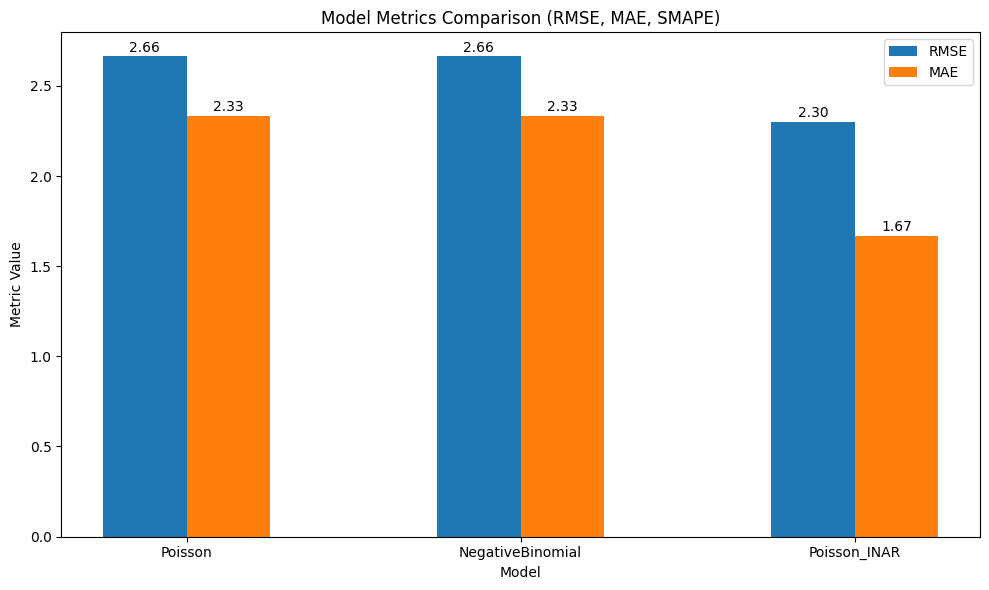

In [39]:
# Plot grouped bar chart
metrics_to_plot = ['RMSE', 'MAE']
x = np.arange(len(models))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(metrics_to_plot):
    ax.bar(x + i * width, metrics_df[metric], width, label=metric)
    # Add metric value labels above the bars
    for j in range(len(models)):
        ax.text(x[j] + i * width, metrics_df[metric][j] + 0.01, f'{metrics_df[metric][j]:.2f}',
                ha='center', va='bottom', fontsize=10)

# Set axis labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Metric Value')
ax.set_title('Model Metrics Comparison (RMSE, MAE, SMAPE)')
ax.set_xticks(x + (width * (len(metrics_to_plot) - 1)) / 2)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

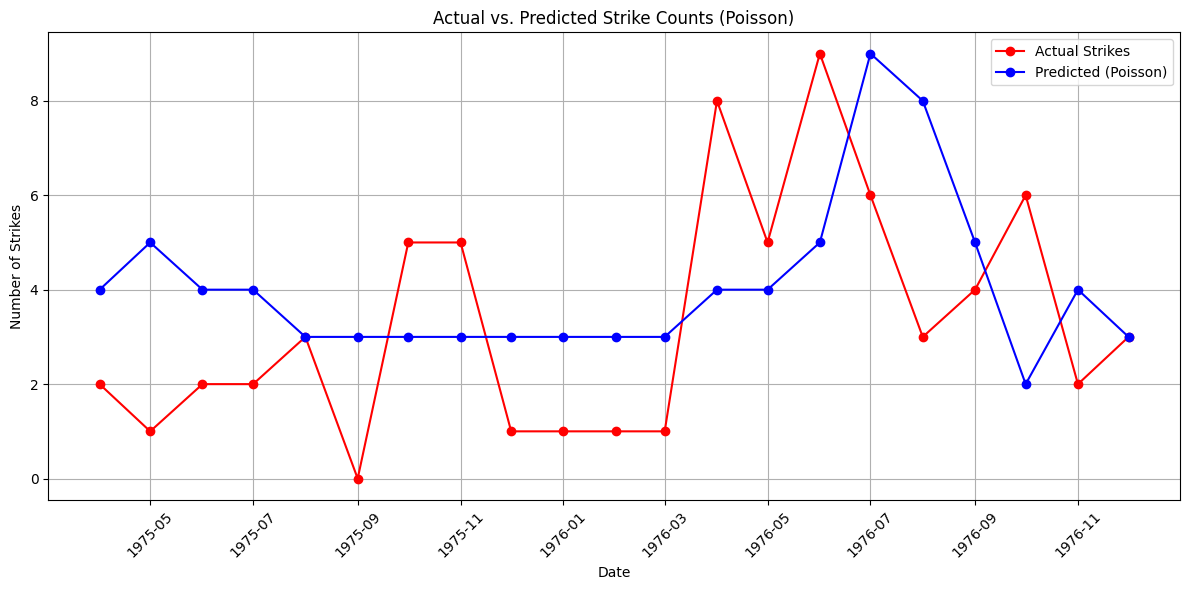

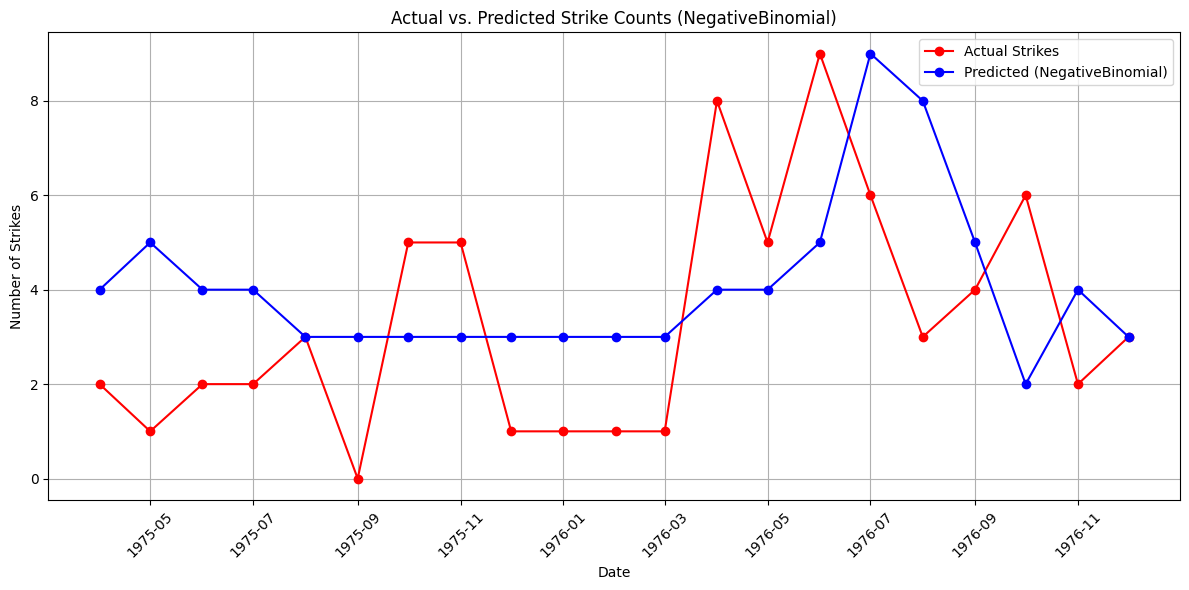

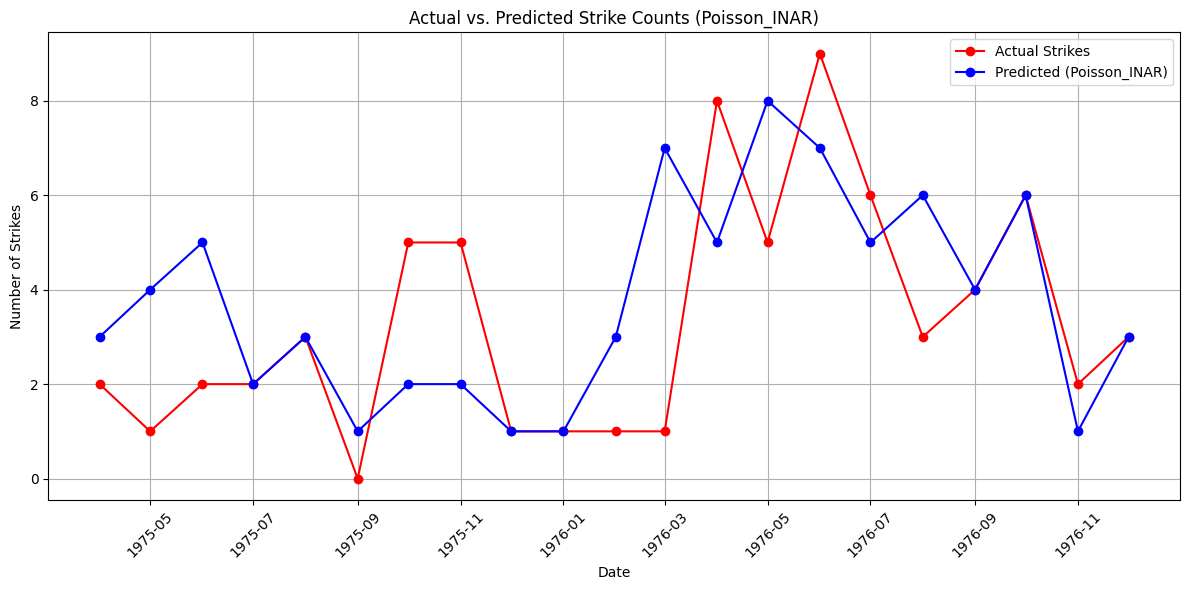

In [40]:
# Plot actual vs. predicted values
model_names = ['Poisson', 'NegativeBinomial', 'Poisson_INAR']
for model in model_names:
    plt.figure(figsize=(12, 6))
    plt.plot(predictions_df['Time'], predictions_df['Actual'], 'ro-', label='Actual Strikes')
    plt.plot(predictions_df['Time'], predictions_df[model], 'bo-', label=f'Predicted ({model})')
    plt.title(f'Actual vs. Predicted Strike Counts ({model})')
    plt.xlabel('Date')
    plt.ylabel('Number of Strikes')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("\n")